In [1]:
import warnings
warnings.filterwarnings('ignore')

# Tutorial 5 - GNNs & PyG Intro
Based on the official PyG tutorials

### Lesson Overview
- Motivation GNNs
- Graph Theory reminder 
- GNNs

### Deep learning is amazing
<div>
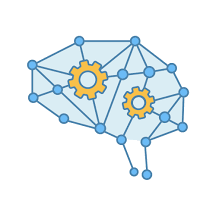
</div>
As we all know, Deep learning performs very well on many different tasks


## Is deep learning always amazing?

- Biology & Chemistry domains
<div>
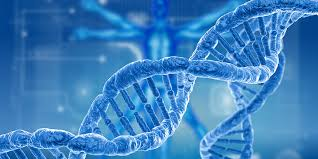
</div>

- Network Science domains
<div>
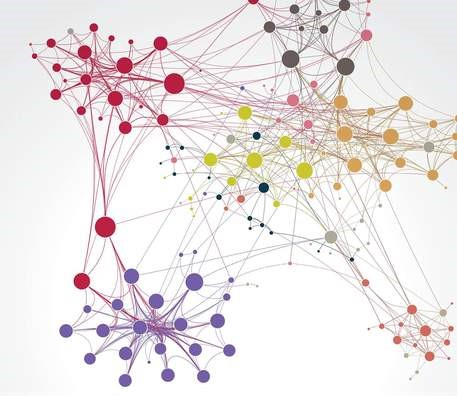
</div>

- Generally non-euclidean domains with complex structures

## Graphs

We can try to model more complex structures using graphs
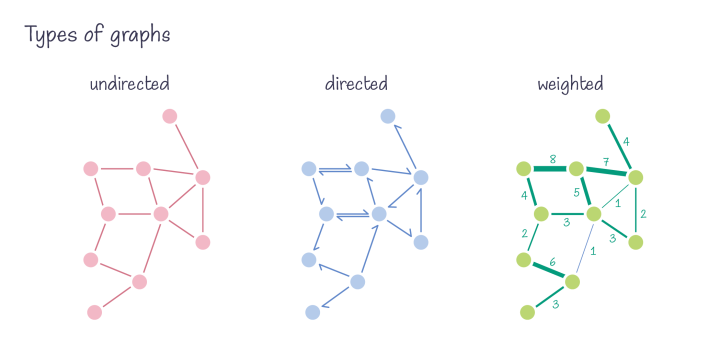

#### Graph Definitions
A graph $G$ is defined as a tuple of sets $G=(V,E)$ <br> 

$V$ is the set of <i>nodes</i>. <br>&emsp;For example: $V=$ {$ v_1, v_2, ...$} <br>
$E$ is the set of <i>edges</i>. <br>&emsp;For example: $E=${$(v_1, v_2), (v_4,v_9),...$}

#### Tasks that we could do
- Node classification
- Edge classification/regression
- Graph prediction

#### Representation
<div>
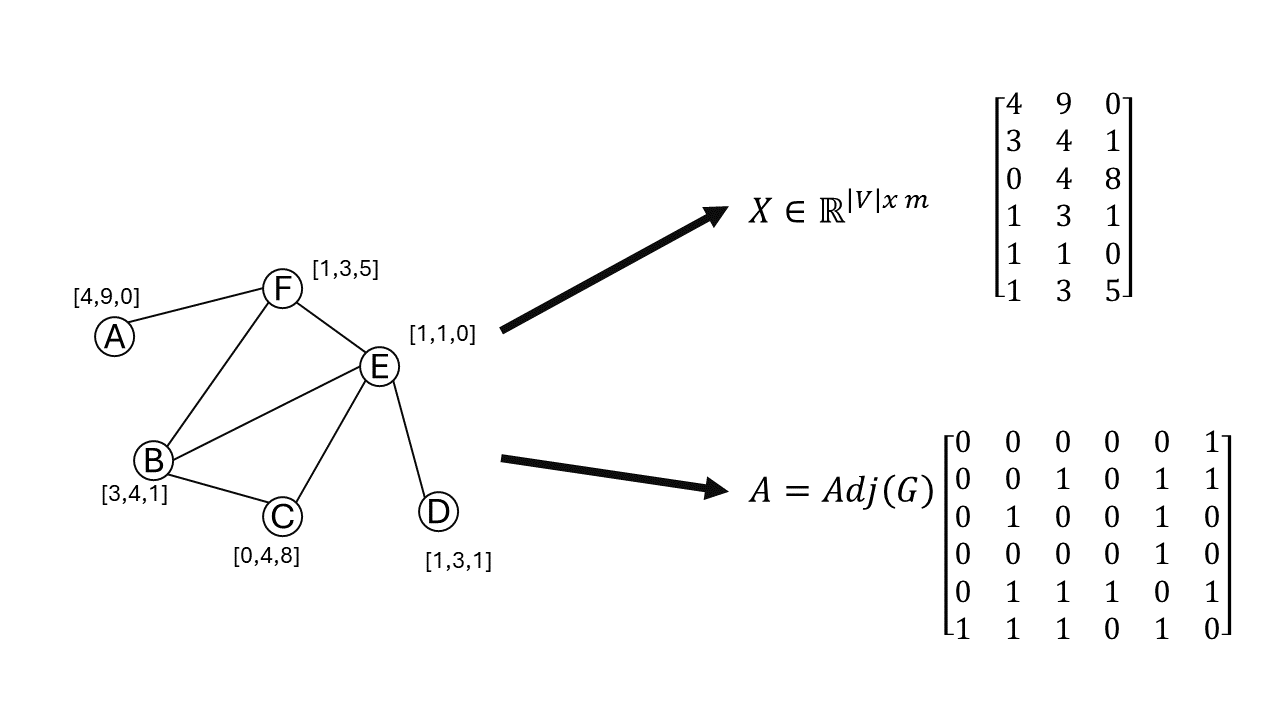
</div>


Can this representation of $ X \in R^{|V| x m}$ and $A=Adj(G)$ be fed as-is into a normal neural network?

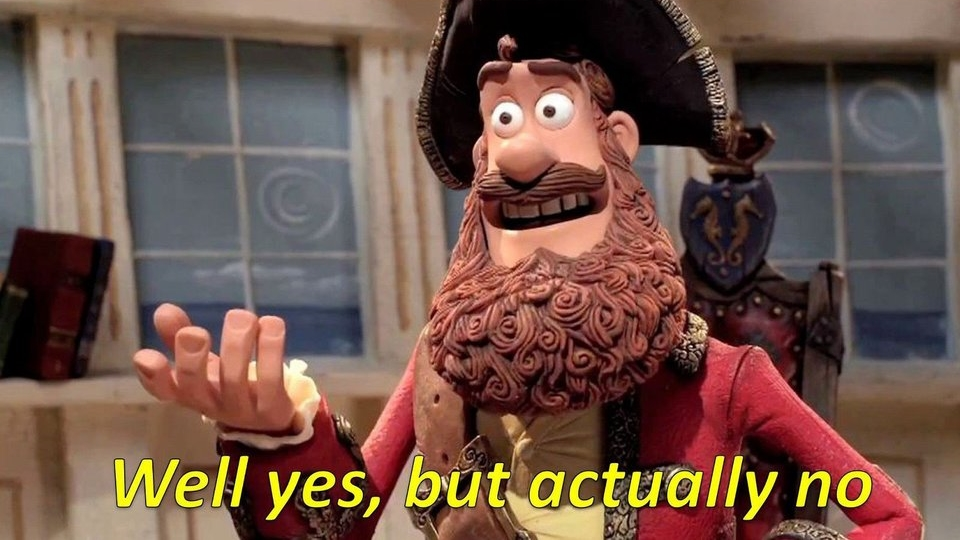

No, since this representation is not <i>order invariant</i>.

# Computation Graph

#### What is it?
A method of creating node embeddings by aggregating a neighborhood of a node in an order invariant way.

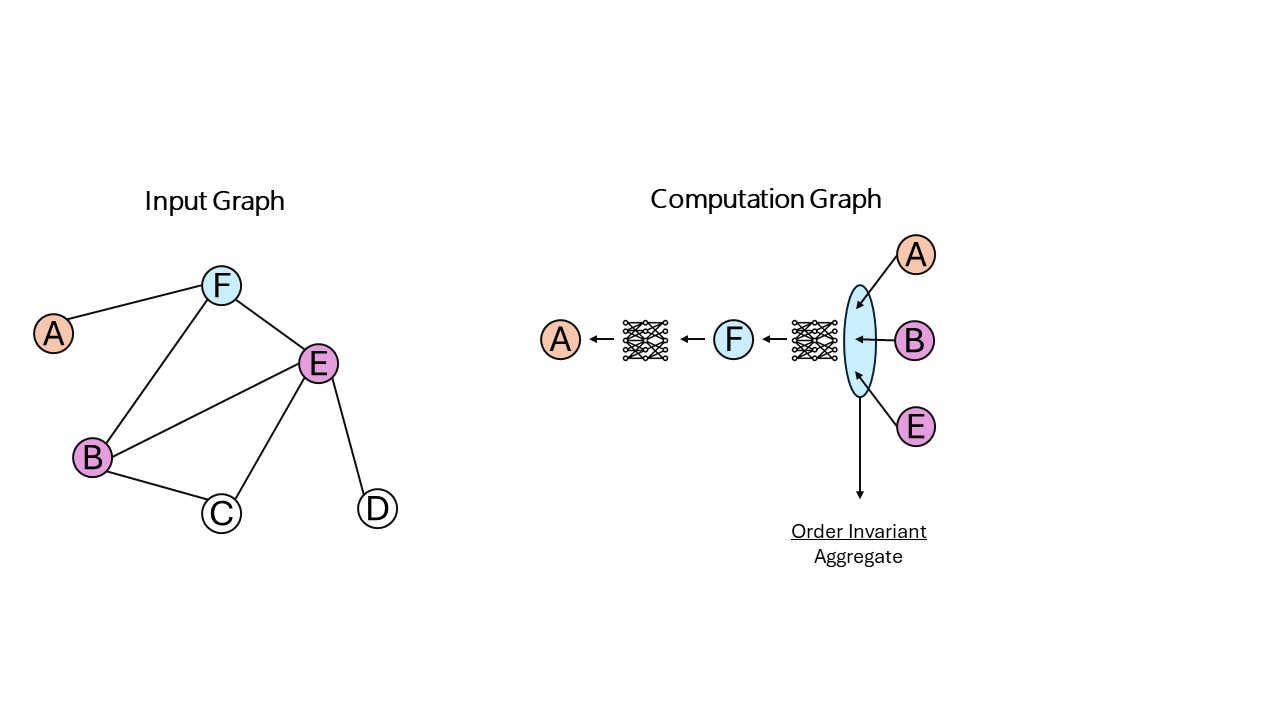

### How many layers should I take?


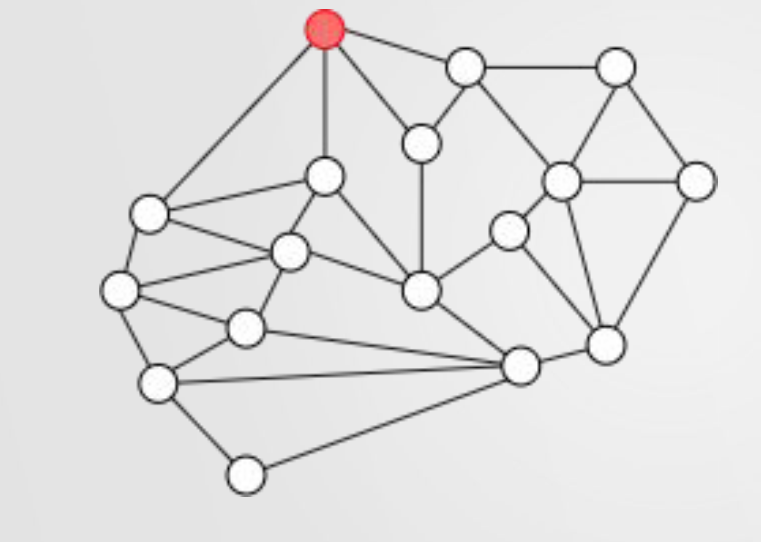

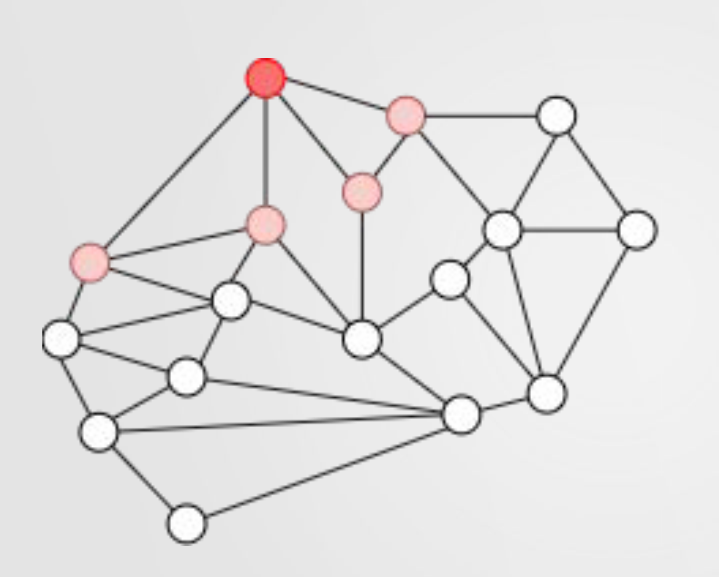

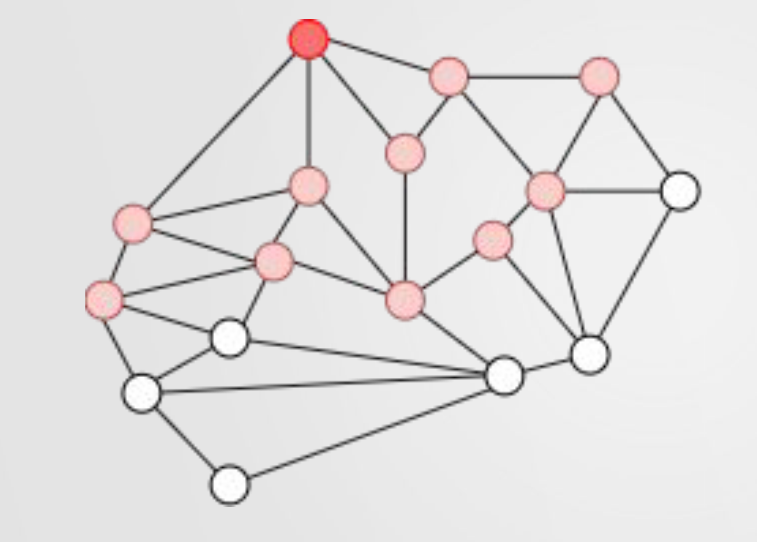
Using a large number of layers can include a very large portion of the graph. <br> <br>
Most nodes see almost the exact same information when calculating their embeddings

## Math
#### Basic GNN layer

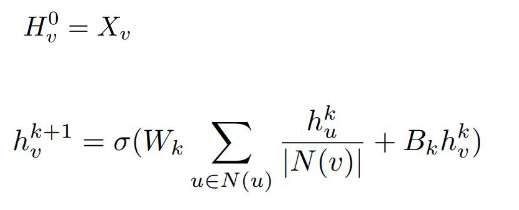
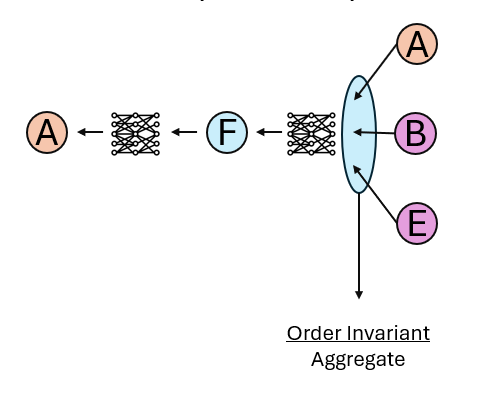

#### GraphSage
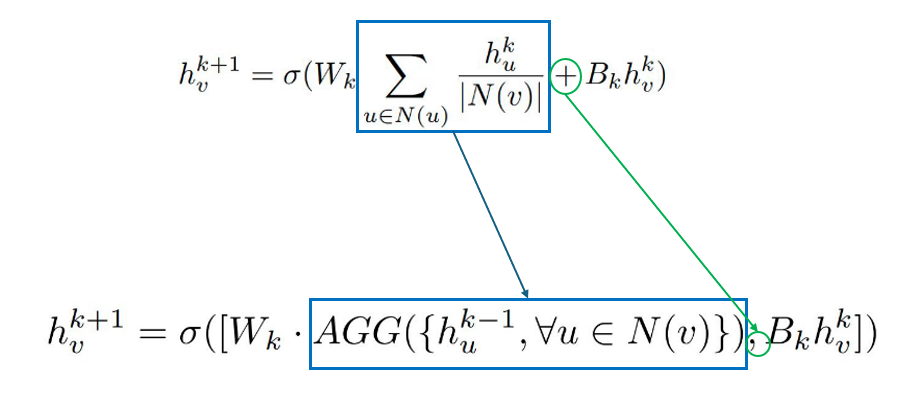

# Now lets see some code

In [1]:
import torch_geometric

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset
The [Coauthor](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Coauthor.html#torch_geometric.datasets.Coauthor) class allows us to download and use the [CS and Physics Co-Authoring datasets](https://arxiv.org/abs/1811.05868)<br>

In [2]:
from torch_geometric.datasets import Coauthor

dataset = Coauthor(root="Tutorial5", name="CS")

Processing...
Done!


<u>Representation</u>: Nodes represent authors that are connected by an edge if they co-authored a paper.<br>
<u>Task</u>: Given paper keywords for each author’s papers, the task is to map authors to their respective field of study out of 15 possible fields
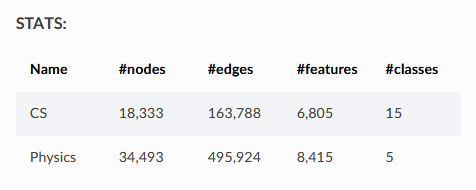

In [3]:
print("edge_index:\n\t", dataset.data.edge_index.shape)
print("\t", dataset.data.edge_index)
print("\n")
print("x:\n\t", dataset.data.x.shape)
print("\t", dataset.data.x)
print("\n")
print("y:\n\t", dataset.data.y.shape)
print("\t", dataset.data.y)

edge_index:
	 torch.Size([2, 163788])
	 tensor([[    0,     0,     0,  ..., 18331, 18331, 18332],
        [ 5111, 12716, 12963,  ..., 14816, 17748,  2582]])


x:
	 torch.Size([18333, 6805])
	 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


y:
	 torch.Size([18333])
	 tensor([13,  2, 13,  ...,  0,  8,  5])


/opt/homebrew/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [13]:
dataset.data.edge_index

/opt/homebrew/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


tensor([[    0,     0,     0,  ..., 18331, 18331, 18332],
        [ 5111, 12716, 12963,  ..., 14816, 17748,  2582]])

In [5]:
import torch
import numpy as np

def create_mask_tensors(num_nodes, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Create boolean mask tensors for train, validation, and test sets.
    Returns:
        Three boolean tensors of shape (num_nodes,) to denote which elements of the tensor are train, validation or test samples
    """
    indices = torch.randperm(num_nodes)
    
    train_size = int(num_nodes * train_ratio)
    val_size = int(num_nodes * val_ratio)
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size+val_size]] = True
    test_mask[indices[train_size+val_size:]] = True
    
    return train_mask, val_mask, test_mask

train_mask, val_mask, test_mask = create_mask_tensors(dataset.data.x.shape[0]) 

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [5]:
# Access the data itself by looking at the first element of the dataset variable
data = dataset[0]
data

Data(x=[18333, 6805], edge_index=[2, 163788], y=[18333])

In [8]:
class OurNet(torch.nn.Module):
    def __init__(self):
        super(OurNet, self).__init__()
        
        # SAGEConv is the pytorch implementation of the GraphSAGE layer we introduced earlier
        self.conv = SAGEConv(
            in_channels=dataset.num_features,
            out_channels=dataset.num_classes,
            aggr="max", # max, mean, add ...)
            normalize=True
        ) 

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

In [9]:
# Set the device 
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')

model, data = OurNet().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

device

device(type='cpu')

In [10]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(data.x, data.edge_index)[train_mask], data.y[train_mask]).backward()
    optimizer.step()

In [11]:
def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [train_mask, val_mask, test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [12]:
best_val_acc = test_acc = 0
for epoch in range(1,20):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'
    
    if epoch % 1 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

Epoch: 001, Val: 0.6465, Test: 0.6722
Epoch: 002, Val: 0.6989, Test: 0.7164
Epoch: 003, Val: 0.7256, Test: 0.7401
Epoch: 004, Val: 0.7365, Test: 0.7562
Epoch: 005, Val: 0.7469, Test: 0.7652
Epoch: 006, Val: 0.7556, Test: 0.7772
Epoch: 007, Val: 0.7720, Test: 0.7835
Epoch: 008, Val: 0.7801, Test: 0.7927
Epoch: 009, Val: 0.7889, Test: 0.8007
Epoch: 010, Val: 0.7971, Test: 0.8088
Epoch: 011, Val: 0.8074, Test: 0.8167
Epoch: 012, Val: 0.8129, Test: 0.8219
Epoch: 013, Val: 0.8156, Test: 0.8266
Epoch: 014, Val: 0.8189, Test: 0.8328
Epoch: 015, Val: 0.8205, Test: 0.8367
Epoch: 016, Val: 0.8249, Test: 0.8418
Epoch: 017, Val: 0.8292, Test: 0.8457
Epoch: 018, Val: 0.8325, Test: 0.8506
Epoch: 019, Val: 0.8369, Test: 0.8538


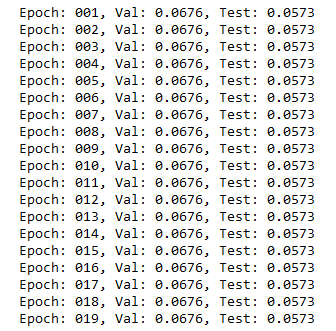

## Thanks for Listening :)